In [1]:
import os
import pandas as pd
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import chromosomeDefinition as cd
import analyseVCF as aVCF
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

In [2]:
CNV_COLUMNS = ['chrom','posStart','posEnd','copyNum','gainOrLoss','BAF','score','germlineOrSomatic','oneOrZero']

In [3]:
# LOAD BED
BED_PATH = "/Users/peterpriestley/hmf/analyses/giabTruthsets/"
BED_FILE_NAME = "NA12878_GIAB_highconf_IllFB-IllGATKHC-CG-Ion-Solid_ALLCHROM_v3.2.2_highconf.bed"
USE_BED = True
LOAD_FULL_FILE = True

### FUNCTIONS

In [4]:
def findFiles(path,suffix):
    files=[]
    for x in os.listdir(path):
        if x[-len(suffix):] == suffix:
            files.append(x)
    return files

In [5]:
def loadCNVforPatient(cnvFile,patientName):
    dfCNV = pd.read_table(cnvFile, names = CNV_COLUMNS )
    #add regions with default copy number
    last = dfCNV.iloc[0]
    for i in range(1, dfCNV.shape[0]-1):
        if last['posEnd']<>dfCNV.iloc[i]['posStart']:
            if last['chrom']==dfCNV.iloc[i]['chrom']:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], dfCNV.iloc[i]['posStart']-1,2,'none','','',0,0]
            else:
                dfCNV.loc[len(dfCNV)] = [last['chrom'],last['posEnd'], cd.chromosomeLength[last['chrom']],2,'none','','',0,0]
                if dfCNV.iloc[i]['posStart']<>0:
                    dfCNV.loc[len(dfCNV)] = [dfCNV.iloc[i]['chrom'],0, dfCNV.iloc[i]['posStart'],2,'none','','',0,0]
        last = dfCNV.iloc[i]
    #fix first record
    if dfCNV.iloc[0]['posStart']<>0:
        dfCNV.loc[len(dfCNV)] = ['1',0, dfCNV.iloc[0]['posStart'],2,'none','','',0,0]
    #Additional Fields
    dfCNV['chromPos']= dfCNV['chrom'].apply(lambda x: cd.intChrom(x)) + dfCNV['posStart'] / dfCNV['chrom'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfCNV['chrom'] = dfCNV['chrom'].apply(lambda x: cd.intChrom(x))
    dfCNV['cappedCopyNum'] = dfCNV['copyNum'].clip(upper=5)
    dfCNV = dfCNV.sort_values(["chrom","posStart","posEnd"]).reset_index()
    dfCNV['regionLength'] = (dfCNV['posEnd']-dfCNV['posStart'])
    dfCNV['patientName']=patientName
    return dfCNV

In [6]:
def calculateMBAFBetween(chrom,minPos,maxPos):
    dftemp = dfBAF[(dfBAF.Chromosome==chrom)&(dfBAF.Position>minPos)&(dfBAF.Position<maxPos)]
    return dftemp['mBAF'].median(),dftemp['mBAF'].count()

In [7]:
def loadBAFData(bafFile):
    df = pd.read_table(bafFile)
    return df

In [8]:
def cnvChart(dfCNV,filename,minChrom=1,maxChrom=23):
    plt.figure(figsize=[18,3])
    plt.title(filename)
    ax = plt.gca()
    ax.plot(dfCNV['chromPos'], dfCNV['copyNum'],drawstyle="steps-post")
    ax.axis([minChrom, maxChrom, 0, 6])
       

In [9]:
def cnvLabel(copyNumber):
    if copyNumber < 2:
        return 'loss'
    elif copyNumber > 2:
        return 'amplification'
    else:
        return'normal'

In [10]:
def createBAF(dfGermline):
    dfBAF = dfGermline[(dfGermline['variantType']=="SNP")&(dfGermline['normalSGT']=="0/1")&(dfGermline['normalAF']>0.4) \
                   &(dfGermline['normalAF']<0.65)&(dfGermline['normalDP']>30)&\
                   (dfGermline['normalDP']<40)][['chrom','pos','tumorAF']]
    dfBAF.columns = ['Chromosome', 'Position','BAF']
    dfBAF['Position'] = pd.to_numeric(dfBAF['Position'])
    dfBAF['mBAF']= 0.5+abs(dfBAF['BAF']-0.5)
    dfBAF['chromPos']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x)) + dfBAF['Position'] / dfBAF['Chromosome'].apply(lambda x: cd.chromosomeLength[str(x)])
    dfBAF['Chromosome']= dfBAF['Chromosome'].apply(lambda x: cd.intChrom(x))
    return dfBAF

In [11]:
def patientIDFromFilename(filename):
    patientIDStart = filename.find("DRUP01")   #
    return filename[patientIDStart:patientIDStart+12]

In [12]:
def germlineVCFSampleNames(filename,patientID):
    return {patientID+'R':'normal',patientID+'T':'tumor'}

In [13]:
def loadVCF(path,filename,sampleNames,patientID):
    df = pd.DataFrame()
    if USE_BED:
        bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True,True,bed,LOAD_FULL_FILE)])
    else:
        return pd.concat([df,aVCF.loadVariantsFromVCF(path,filename,sampleNames,patientID,True)])

In [14]:
def AFByPosPlot(pos,AF,startChartPos,endChartPos):
    plt.figure(figsize=[18,5])
    plt.scatter(pos, AF)
    plt.grid(b=True, which='both', color='0.65',linestyle='-')
    plt.axis([startChartPos, endChartPos,0, 1.0])
    plt.show()

In [15]:
def loadPON(aPath,aPONFile):
    myPON = []
    with open(aPath + aPONFile, 'r') as f:
        for line in f:
            line = line.strip('\n')
            splitLine = line.split('\t')
            myPON.append(splitLine)
    dfPON = pd.DataFrame(myPON)
    dfPON.columns = ['chrom','pos','ref','alt','PONCount']
    return dfPON

In [16]:
def findPeaks(log_dens):
    peaks = []
    troughs = []
    dens=np.exp(log_dens)
    diff = [dens[x] - dens[x-1] for x in range(1,len(dens))]
    for i in range (len(diff)-1):
        if diff[i+1] < 0 and diff[i] > 0:
            peaks.append(float(i+1)/len(dens))
        if diff[i+1] > 0 and diff[i] < 0:
            troughs.append(float(i+1)/len(dens))
    return peaks, troughs

In [17]:
def pdfChart(log_dens,maxYValue=8):
    fig, ax = plt.subplots()
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format('gaussian'))
    ax.legend(loc='upper right')
    fig.set_figwidth(10)
    fig.set_figheight(5)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.02, maxYValue)
    ax.grid(b=True, which='both', color='0.65',linestyle='-')
    plt.show()

### LOAD PON

In [ ]:
# Only needs to be run once
dfPON = loadPON("/Users/peterpriestley/hmf/analyses/PON/779filePON/","PON.tsv")

### FIND ALL FILES

In [ ]:
PATH = "/Users/peterpriestley/hmf/analyses/v1.12samples/DRUP01050003/"

In [10]:
germlineVCFFilename

'170121_HMFregCPCT_FR12246044_FR13981247_CPCT02300003.annotatedSLICED.vcf'

In [28]:
germlineVCFFilename = findFiles(PATH,"SLICED.vcf")[0]
somaticVCFFilename = findFiles(PATH,"melted.vcf")[0]
patientID = patientIDFromFilename(germlineVCFFilename)
cnvFilename = findFiles(PATH,"gz_CNVs")[0]
print "germline =",germlineVCFFilename
print "somatic =",somaticVCFFilename
print "patient =",patientID
print "CNV =",cnvFilename

germline = 170121_HMFregCPCT_FR12246044_FR13981247_CPCT02300003.annotatedSLICED.vcf
somatic = CPCT02300003R_CPCT02300003T_merged_somatics_annotated_melted.vcf
patient = CPCT02300003
CNV = CPCT02300003T_dedup.realigned.bam_CNVs


### LOAD VCFS

In [29]:
#LOAD VCFS
dfGermline = loadVCF(PATH,germlineVCFFilename,{patientID+'R':'normal',patientID+'T':'tumor'},patientID)
dfSomatic = loadVCF(PATH,somaticVCFFilename,{patientID+'T':'melted'},patientID)

reading vcf file: 170121_HMFregCPCT_FR12246044_FR13981247_CPCT02300003.annotatedSLICED.vcf
reading VCF File line: 1
reading VCF File line: 200001
Number variants loaded: 345047
reading vcf file: CPCT02300003R_CPCT02300003T_merged_somatics_annotated_melted.vcf
reading VCF File line: 1
Number variants loaded: 41757


In [31]:
# APPLY PON to SOMATICs
dfSomatic['alt'] = dfSomatic['meltedallele']
dfSomatic = pd.merge(dfSomatic,dfPON,how='left', on=['chrom','pos','ref','alt'])
dfSomatic['PONCount'].fillna(0, inplace=True)
dfSomatic['inPON'] = pd.to_numeric(dfSomatic.PONCount,errors=coerce)>4

### Load BAF and CNV and calculate median BAF per segment

In [77]:
dfBAF = createBAF(dfGermline)

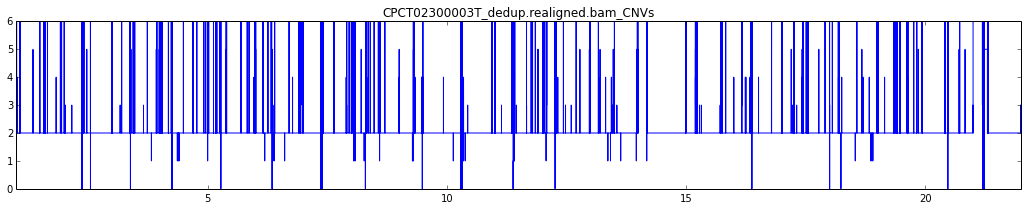

In [78]:
dfCNV = loadCNVforPatient(PATH+cnvFilename,patientID)
dfCNV['mBAF'], dfCNV['mBAFCount'] = np.vectorize(calculateMBAFBetween)(dfCNV['chrom'], dfCNV['posStart'],dfCNV['posEnd'])
cnvChart(dfCNV,cnvFilename,1,22)

### TUMOR PURITY

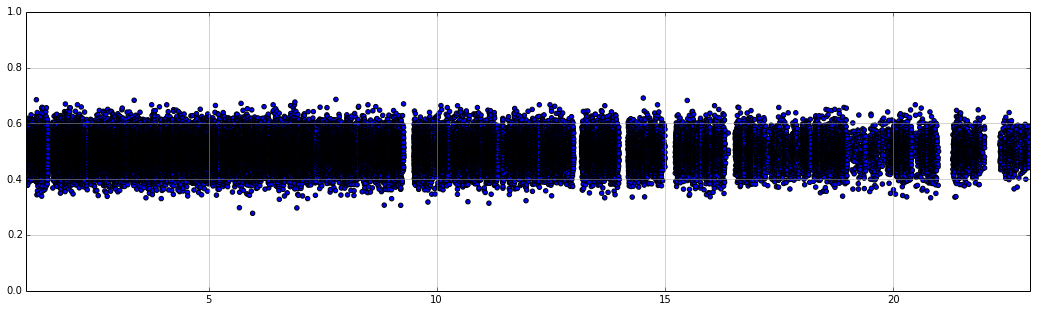

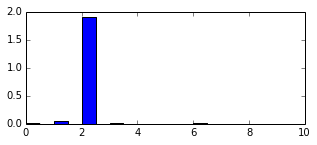

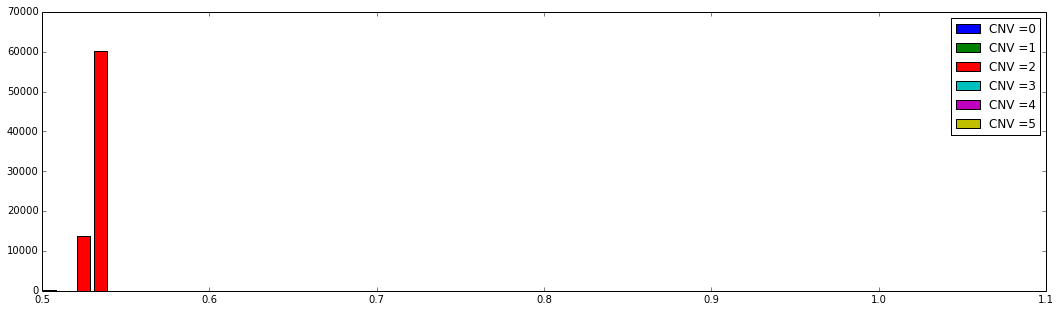

In [79]:
c = 1
fractionMin = 0
fractionMax = 22
dfSom = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
plt.figure(figsize=[18,5])
plt.scatter(dfSom.chromPos, dfSom.BAF)
plt.grid(b=True, which='both', color='0.65',linestyle='-')
plt.axis([c+fractionMin, c+fractionMax,0, 1.0])
plt.show()
# CNV according to freeC
plt.figure(figsize=[5,2])
plt.hist(dfCNV['copyNum'].values,cumulative=False, normed=True, bins=20,range=(0,10),weights=dfCNV['regionLength'].values)
plt.show()
# should only use regions with mbaf > x
c,fractionMin,fractionMax = 1,0,22
dftemp = dfCNV[(dfCNV.mBAF>=0.0)&(dfCNV.mBAF<=1.0)&(dfCNV.mBAFCount>20)&(dfCNV.chromPos<=c+fractionMax)&(dfCNV.chromPos>=c+fractionMin)]
plt.figure(figsize=[18,5])
for CNV in range(0,6):
    plt.hist(dftemp[(dftemp.copyNum==CNV)]['mBAF'].values,cumulative=False, normed=False, bins=50,range=(0.5,1.0),weights=dftemp[(dftemp.copyNum==CNV)]['mBAFCount'].values,stacked = True,rwidth=0.8,label='CNV ='+str(CNV))
    plt.legend()
plt.show()

In [35]:
dfCNV[(dfCNV.chrom>1)&(dfCNV.copyNum>=3)&(dfCNV.mBAF>0.8)&(dfCNV.mBAF<0.87)\
      &(dfCNV.mBAFCount>5)][['chrom','posStart','copyNum','chromPos','regionLength','mBAF','mBAFCount']]

,chrom,posStart,copyNum,chromPos,regionLength,mBAF,mBAFCount


### SOMATIC AF

In [66]:
#dfSomatic[(dfSomatic.consensus==True)&((dfSomatic.annWorstImpact=='MODERATE')|(dfSomatic.annWorstImpact=='HIGH'))]

In [67]:
#pd.pivot_table(dfSomatic[dfSomatic.consensus==True], values='pos', index=['patientName','variantType','inPON'], columns=['annWorstImpact'], aggfunc='count',margins=False).fillna("")

In [37]:
pd.pivot_table(dfSomatic[(dfSomatic.variantType == 'SNP')&(dfSomatic.consensus == True)&(dfSomatic.inPON == False)], values='pos', index=['ref'], columns=['meltedallele'], aggfunc='count',margins=True).fillna("")

meltedallele,A,C,G,T,All
ref,,,,,
A,,14,37,7,58.0
C,11,,11,28,50.0
G,31,6,,7,44.0
T,5,41,9,,55.0
All,47,61,57,42,207.0


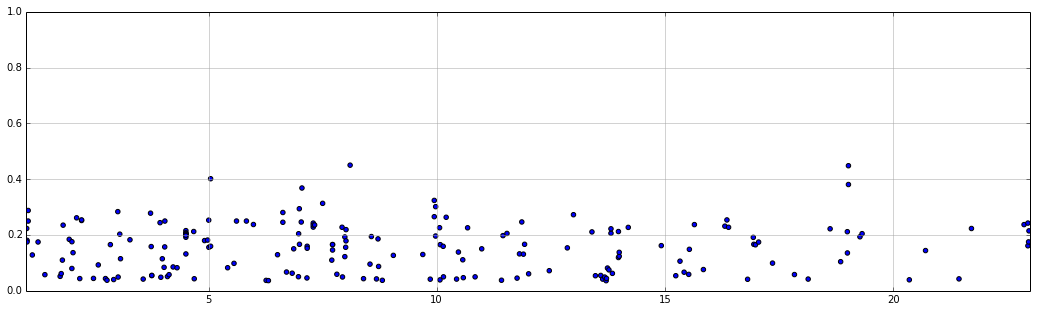

In [57]:
c,fractionMin,fractionMax = 1,0,22
dfSom = dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)&(dfSomatic.chromFrac>c+fractionMin)&(dfSomatic.chromFrac<c+fractionMax)]
AFByPosPlot(dfSom.chromFrac, dfSom.meltedAF,c+fractionMin, c+fractionMax)

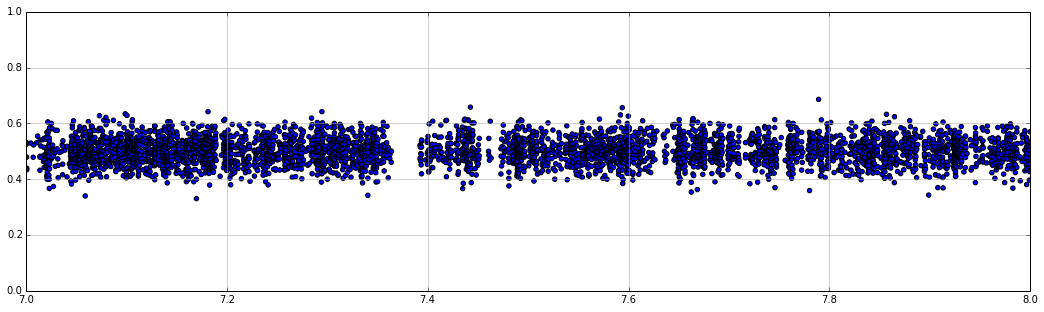

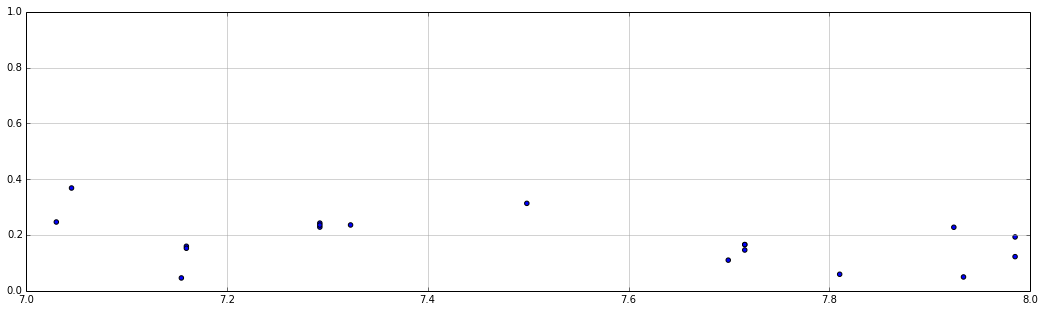

,chrom,posStart,copyNum,chromPos,regionLength,mBAF,mBAFCount
473,7,56889000,2,7.357481,720999,0.515464,9
504,7,61986000,2,7.389509,2727999,0.524531,44
512,7,65059000,2,7.408820,35581999,0.529412,900
514,7,100645000,2,7.632436,1477999,0.535957,10
517,7,102219000,2,7.642327,39822999,0.531746,1073
519,7,142048000,2,7.892605,1493999,0.533333,27
521,7,143550000,2,7.902044,348999,0.526316,15
526,7,144051000,2,7.905192,7882999,0.531532,255
530,7,151987000,2,7.955060,7151664,0.531250,173


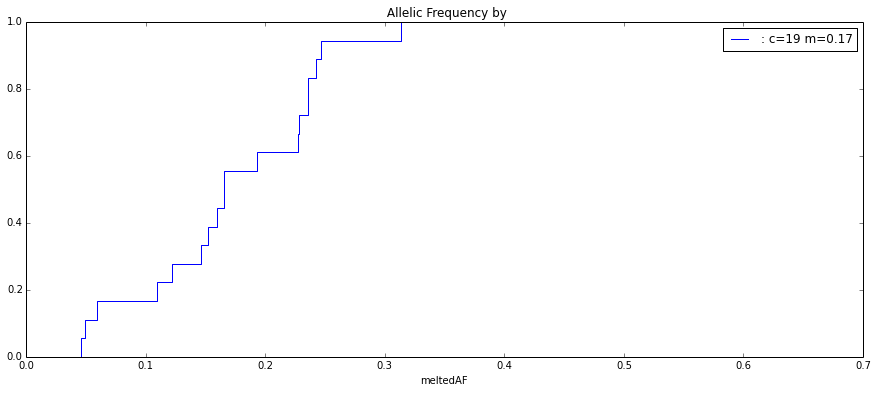

In [64]:
c,fractionMin,fractionMax = 7,0,1
dfTemp = dfBAF[(dfBAF.chromPos>c+fractionMin)&(dfBAF.chromPos<c+fractionMax)]
AFByPosPlot(dfTemp.chromPos, dfTemp.BAF,c+fractionMin, c+fractionMax)
dfSom = dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)&(dfSomatic.chromFrac>c+fractionMin)&(dfSomatic.chromFrac<c+fractionMax)]
AFByPosPlot(dfSom.chromFrac, dfSom.meltedAF,c+fractionMin, c+fractionMax)

#CDF
ser = dfSom.meltedAF.sort_values()
cum_dist = np.linspace(0.,1.,len(ser))
ser_cdf = pd.Series(cum_dist, index=ser,name=": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by ",figsize=[15,6],xlim=[0.0,0.7])

#mbaf
dfCNV[(dfCNV.chromPos>c+fractionMin)&(dfCNV.chromPos<c+fractionMax)&(dfCNV.mBAFCount>5)][['chrom','posStart','copyNum','chromPos','regionLength','mBAF','mBAFCount']]

### PDF peak fMinding

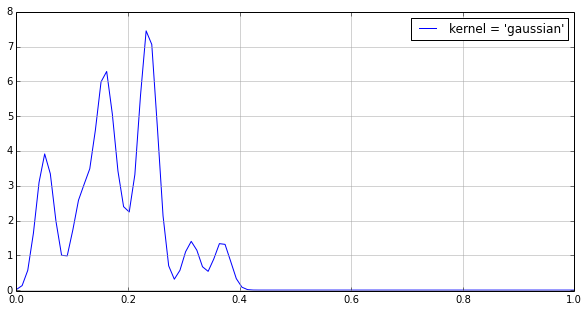

([0.05, 0.16, 0.23, 0.31, 0.36], [0.09, 0.2, 0.28, 0.34])

In [68]:
#dfSom.plot(y='meltedAF', kind='kde', figsize=(10, 6))
#dfSom = dfSomatic[(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)&(dfSomatic.chromFrac>c+fractionMin)&(dfSomatic.chromFrac<c+fractionMax)]
#ser = dfSom.meltedAF.sort_values()
#cum_dist = np.linspace(0.,1.,len(ser))
#ser_cdf = pd.Series(cum_dist, index=ser,name=": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
#ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by ",figsize=[15,3],xlim=[0.0,0.8])

X = dfSom.meltedAF.sort_values()[:, np.newaxis]
X_plot = np.linspace(0,1,100)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.015).fit(X)
log_dens = kde.score_samples(X_plot)
pdfChart(log_dens)
findPeaks(log_dens)

### SCRATCH

In [ ]:
chromosomes = ['4']#dfSomatic['chrom'].unique()
for chromosome in chromosomes:
    try:
        ser = dfSomatic[(dfSomatic.chrom==chromosome)&(dfSomatic['variantType']=="SNP")&(dfSomatic['inPON']==False)&(dfSomatic['consensus']==True)]["meltedAF"]
        ser = ser.sort_values()
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=str(chromosome))
        ser_cdf.plot(drawstyle='steps',legend=True,title="BAF By Chromosome",figsize=[13,3],xlim=[0.0,0.8],ylim=[0.0,1.0])
    except TypeError:
        continue

In [ ]:
### TUMOR PURITY

In [ ]:
dftemp.head()

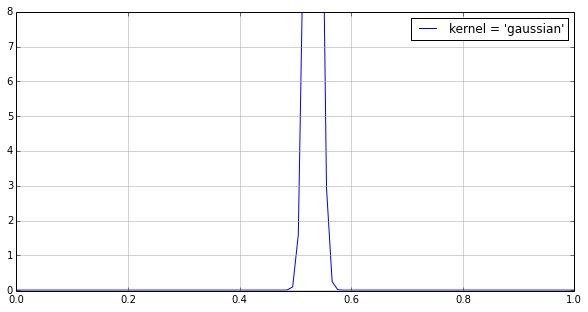

([0.53], [])

In [47]:

X = dftemp.mBAF.sort_values()[:, np.newaxis]
X_plot = np.linspace(0,1,100)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.01).fit(X)
log_dens = kde.score_samples(X_plot)
pdfChart(log_dens)
findPeaks(log_dens)